In [63]:
import pickle as pkl
import sys
import torch
import builder
import torchvision.models as models
import numpy as np
import torchvision.datasets as datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import xml.etree.ElementTree as ET
from PIL import Image
import os

In [163]:
class PascalVOCDataset(Dataset):
    
    def __init__(self, data_folder, split):

        split.lower()
        assert split in {'train', 'test'}

        self.split = split
        self.data_folder = data_folder
        
        #train+val come from both 2007 and 2012, test comes from 2007
        if split == 'train': 
            loc = [data_folder + '/VOCdevkit/VOC2007/ImageSets/Main/trainval.txt',
                   data_folder + '/VOCdevkit/VOC2012/ImageSets/Main/trainval.txt']
        elif split == 'test':
            loc = [data_folder + '/VOCdevkit/VOC2007/ImageSets/Main/test.txt']
        
        
        self.images = []
        self.file_names = []

        #Get the Image locations for each of the datasets 
        for file in loc:
            image_path = file[0:len('datasets/VOCdevkit/VOC2007///')] + 'JPEGImages/'

            with open(file,'rb') as f:
                content = f.readlines()
            [self.images.append(image_path + (x.strip().decode('utf-8')) + '.jpg') for x in content]
            [self.file_names.append(x.strip().decode('utf-8')) for x in content]
      
    
        #Get the Associated Objects (Bounding boxes, etc)
        self.objects = []
        
        for xml in self.file_names:
            if os.path.isfile('./datasets/VOCdevkit/VOC2007/Annotations/' + xml + '.xml'):
                output = read_content('./datasets/VOCdevkit/VOC2007/Annotations/' + xml + '.xml')
                self.objects.append(output)
            elif os.path.isfile('./datasets/VOCdevkit/VOC2012/Annotations/' + xml + '.xml'):
                output = read_content('./datasets/VOCdevkit/VOC2012/Annotations/' + xml + '.xml')
                self.objects.append(output)
        
        print(len(self.images), len(self.objects))
    def __getitem__(self,i):
        
        image = Image.open(self.images[i], mode = 'r')
        image = image.convert('RGB')
        
        objects = self.objects[i]
        print(objects)
        boxes = torch.FloatTensor(objects[0])
        
        labels = torch.LongTensor(objects[1])
        
        show(image, boxes.numpy())

        return image, boxes, labels
    
    
    
    
    def __len__(self):
        return len(self.images)

16551 16551
4952 4952
([[69, 172, 270, 330], [150, 141, 229, 284], [285, 201, 327, 331], [258, 198, 297, 329]], [13, 15, 15, 15])


(<PIL.Image.Image image mode=RGB size=500x375 at 0x7F04FE55C2E0>,
 tensor([[ 69., 172., 270., 330.],
         [150., 141., 229., 284.],
         [285., 201., 327., 331.],
         [258., 198., 297., 329.]]),
 tensor([13, 15, 15, 15]))

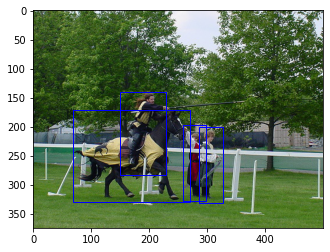

In [166]:
train_data = PascalVOCDataset('./datasets', 'train')
test_data = PascalVOCDataset('./datasets', 'test')

train_data[2]

In [146]:
def read_content(xml_file: str):

    tree = ET.parse(xml_file)
    root = tree.getroot()

    list_with_all_boxes = []
    
    labels = []
    for boxes in root.iter('object'):

        filename = root.find('filename').text

        ymin, xmin, ymax, xmax = None, None, None, None

        for box in boxes.findall("bndbox"):
            ymin = int(box.find("ymin").text)
            xmin = int(box.find("xmin").text)
            ymax = int(box.find("ymax").text)
            xmax = int(box.find("xmax").text)

        list_with_single_boxes = [xmin, ymin, xmax, ymax]
        list_with_all_boxes.append(list_with_single_boxes)
        
        labels.append(boxes.find('name').text)

    return (list_with_all_boxes, oneHotEncodeClassLabels(labels))



In [147]:
width = 316-194
height = 500-185
output[1]


['bus', 'car', 'car', 'person', 'person', 'person', 'car']

In [162]:
import matplotlib.patches as patches

def show(image, bbs):
    fig, ax = plt.subplots(1)
    plt.imshow(image)

    for bb in bbs:
        height = bb[3] - bb[1]
        width = bb[2] - bb[0]
        rect = patches.Rectangle((bb[0],bb[1]),width,height,linewidth=1,edgecolor='b',facecolor='none')
        ax.add_patch(rect)

In [140]:
def oneHotEncodeClassLabels(labels : list):
    classes = ['background','aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
    one_hot = [classes.index(i) for i in labels] 
    return one_hot


In [141]:
oneHotEncodeClassLabels(['bird', 'bird', 'bottle', 'pottedplant'])

[3, 3, 5, 16]